Triton: 
Avg Time taken: 0.0027 seconds
C OpenMP:
Avg Time taken: 0.0042 seconds


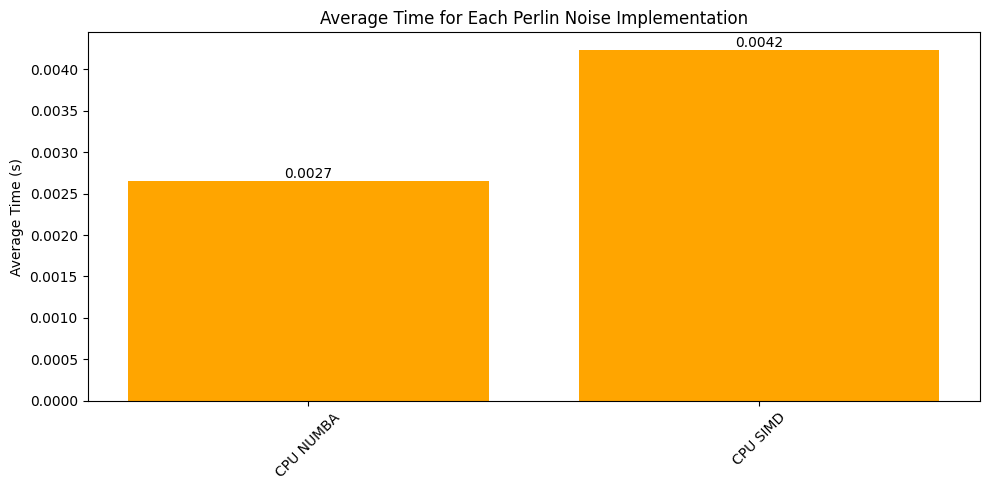

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import time
import triton
import triton.language as tl
from torch_perlin import get_grid, torch_perlin_noise
from utils import get_avg_time
from C_wrapper import C_perlin_noise, init_C, C_perlin_noise_mp
from naive_python import perlin_noise
from naive_triton import perlin_noise_triton

scale = 4
runs = 200

images = []
avg_times = []  # List to store average times
titles = ["CPU NUMBA", "CPU SIMD", "CUDA", "CUDA Compiled", "Triton", "C OpenMP", "C"]

size = torch.tensor([2048, 2048])
scale = 4
w, h = size
x = torch.linspace(0, scale, w)
y = torch.linspace(0, scale, h)
x, y = torch.meshgrid(x, y, indexing="ij")
out = torch.zeros_like(x)
grads = torch.tensor([[1, 0], [-1, 0], [0, 1], [0, -1]], dtype=torch.float32)
perm = torch.randint(0, 256, (256*2 + 3,), dtype=torch.int32)

print("CPU NUMBA:")
perlin_image, avg = get_avg_time(200, perlin_noise, perm.numpy(), int(size[0]), int(size[1]), scale, grads.numpy())
images.append(np.array(perlin_image).reshape(size.numpy()))
avg_times.append(avg)

print("CPU SIMD:")
perlin_image, avg = get_avg_time(200, torch_perlin_noise, perm, x, y, grads)
images.append(perlin_image)
avg_times.append(avg)

print("Cuda:")
perlin_image, avg  = get_avg_time(runs, torch_perlin_noise, perm.cuda(), x.cuda(), y.cuda(), grads.cuda())
images.append(perlin_image)
avg_times.append(avg)

print("Cuda compiled:")
perlin_noise_cuda = torch.compile(torch_perlin_noise)
perlin_image, avg = get_avg_time(200, perlin_noise_cuda, perm.cuda(), x.cuda(), y.cuda(), grads.cuda())
images.append(perlin_image)
avg_times.append(avg)

print("Triton: ")
perlin_image, avg = get_avg_time(runs, perlin_noise_triton, x.cuda(), y.cuda(), perm.cuda(), grads.cuda(), out.cuda(), 1024)
images.append(perlin_image)
avg_times.append(avg)

print("C OpenMP:")
perms, grad, output = init_C(perm, grads, size[0], size[1])
perlin_image, avg = get_avg_time(200, C_perlin_noise_mp, perm, size[0], size[1], scale, grads)
images.append(perlin_image)
avg_times.append(avg)

print("C:")
perms, grad, output = init_C(perm, grads, size[0], size[1])
perlin_image, avg = get_avg_time(200, C_perlin_noise, perm, size[0], size[1], scale, grads)
images.append(perlin_image)
avg_times.append(avg)

plt.figure(figsize=(10, 5))
bars = plt.bar(titles, avg_times, color='orange')
plt.ylabel('Average Time (s)')
plt.title('Average Time for Each Perlin Noise Implementation')
plt.xticks(rotation=45)
plt.tight_layout()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval,4), ha='center', va='bottom')
plt.show()


In [18]:
2**10

1024

In [2]:
images[0].sum(), images[1].sum(), images[2].sum(), images[3].sum(), images[4].sum() ,images[5].sum(), images[6].sum()

(tensor(112310.6094),
 tensor(112310.5938),
 tensor(112310.6094),
 112347.22,
 112347.22)

In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import time
import triton
import triton.language as tl
from torch_perlin import get_grid, torch_perlin_noise
from utils import get_avg_time
from C_wrapper import C_perlin_noise, init_C, C_perlin_noise_mp
from naive_python import perlin_noise
from naive_triton import perlin_noise_triton

size = torch.tensor([2048, 2048])
scale = 4
w, h = size
x = torch.linspace(0, scale, w)
y = torch.linspace(0, scale, h)
x, y = torch.meshgrid(x, y, indexing="ij")
out = torch.zeros_like(x)
grads = torch.tensor([[1, 0], [-1, 0], [0, 1], [0, -1]], dtype=torch.float32)
perm = torch.randint(0, 256, (256*2 + 3,), dtype=torch.int32)


# Compute noise
noise2, _  = get_avg_time(200, torch_perlin_noise, perm.cuda(), x.cuda(), y.cuda(), grads.cuda())

noise1, _ = get_avg_time(200, perlin_noise_triton, x.cuda(), y.cuda(), perm.cuda(), grads.cuda(), out.cuda())

print(noise1.sum(), noise2.sum())
# print("Cuda compiled:")
# device = "cuda"
# perlin_noise_cuda = torch.compile(torch_perlin_noise)
# perlin_image, avg_time = get_avg_time(200, perlin_noise_cuda, perm.to(device), x.cuda(), y.cuda())


Avg Time taken: 0.0071 seconds
Avg Time taken: 0.0017 seconds
tensor(74824.9922) tensor(74824.9453)


In [35]:
x = torch.randint(0, 256, (256*2 + 3,), dtype=torch.int32)[256*2 + 2]
x.cuda()
x

tensor(54, dtype=torch.int32)

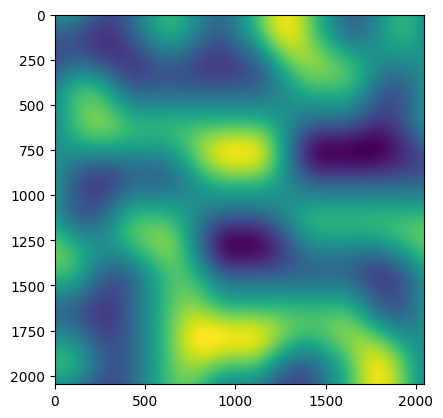

In [191]:
plt.imshow(noise2)

(<matplotlib.image.AxesImage at 0x7fead7342a80>,)

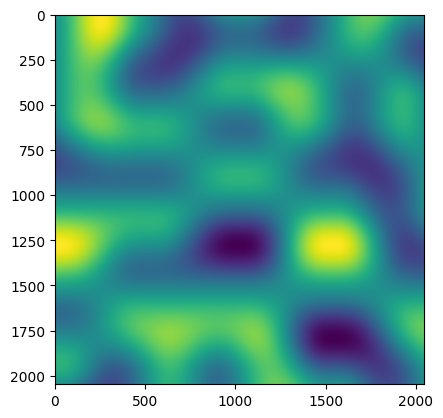

In [3]:
plt.imshow(noise1), 